In [5]:
import numpy as np
from PIL import Image
import cv2

def load_attrib_image(path, target_size=None, keep_uint8=False):
    # load image (RGB or grayscale), convert to single-channel float
    im = Image.open(path).convert('RGB')
    arr = np.asarray(im)  # H,W,3
    # if image is a colored heatmap, collapse to luminance (approx)
    gray = (0.2989*arr[...,0] + 0.5870*arr[...,1] + 0.1140*arr[...,2])
    if target_size is not None:
        gray = cv2.resize(gray, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    if keep_uint8:
        return gray
    return gray.astype(np.float32)

def normalize_map(m):
    m = np.abs(m).astype(np.float32)
    if m.max() <= 1e-12:
        return m
    return (m - m.min()) / (m.max() - m.min() + 1e-12)

# Example usage:
p_shap = [
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4876.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4880.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4881.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4882.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4883.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4886.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4874.png",
    r"C:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\finding\final shap\4875.png"
]
p_grad = [
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1954_bacteria_4886.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4874.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1947_bacteria_4876.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1949_bacteria_4880.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1950_bacteria_4881.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1951_bacteria_4882.jpeg",
    r"D:\datasets\chest_xray\val\PNEUMONIA\person1952_bacteria_4883.jpeg"
]


# first load shap to get shape (or choose a desired size)



idx = 2


m1 = load_attrib_image(p_shap[idx], target_size=None)
m2 = load_attrib_image(p_grad[idx], target_size=m1.shape[:2])  # ensure same HxW

map_shap = normalize_map(m1)
map_gradcam = normalize_map(m2)

# quick sanity prints
print("shap shape:", map_shap.shape, "min/max:", map_shap.min(), map_shap.max())
print("gradcam shape:", map_gradcam.shape, "min/max:", map_gradcam.min(), map_gradcam.max())

# save preprocessed arrays if you want
np.save("map_shap.npy", map_shap)
np.save("map_gradcam.npy", map_gradcam)


shap shape: (431, 434) min/max: 0.0 1.0
gradcam shape: (431, 434) min/max: 0.0 1.0


In [ ]:
# ------------------------------
# Sparsity + Faithfulness (AOPC)
# ------------------------------
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os


orig_img_path = r"D:\datasets\chest_xray\val\PNEUMONIA\person1946_bacteria_4875.jpeg"   
true_class_index = 1                        
maps = {"SHAP": map_shap, "GradCAM": map_gradcam}

PERTURB_BASELINE = 'mean'

PERT_FRACS = [0.01, 0.03, 0.05, 0.1, 0.2]  


OUT_CSV = "explainability_metrics_summary.csv"



def normalize_map(m):
    m = np.array(m, dtype=np.float32)
    
    m -= m.min()
    if m.max() > 0:
        m /= (m.max() + 1e-12)
    return m

def compute_sparsity_topmass(attrib_map, mass_thresh=0.90):
    
    nm = np.abs(attrib_map).ravel().astype(np.float32)
    if nm.sum() == 0:
        return 1.0
    order = np.argsort(-nm)
    cum = np.cumsum(nm[order])
    k = np.searchsorted(cum, mass_thresh) + 1
    return float(k / nm.size)


def load_image_rgb(path, target_size=None):
    im = Image.open(path).convert("RGB")
    arr = np.asarray(im).astype(np.float32) / 255.0
    if target_size is not None:
        arr = cv2.resize(arr, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    return arr 


def apply_perturbation(img, indices_to_perturb, baseline='mean'):
    
    H, W = img.shape[:2]
    flat = img.reshape(-1, 3).copy()
    if baseline == 'mean':
        fill = img.mean(axis=(0,1))
        flat[indices_to_perturb, :] = fill.reshape(1, 3)
    elif baseline == 'black':
        flat[indices_to_perturb, :] = 0.0
    elif baseline == 'blur':
        # reconstruct mask and apply gaussian blur to that region
        mask = np.zeros((H, W), dtype=np.uint8).ravel()
        mask[indices_to_perturb] = 1
        mask = mask.reshape(H, W)
        blurred = cv2.GaussianBlur((img*255).astype(np.uint8), (21,21), 0).astype(np.float32)/255.0
        flat_mask = mask.reshape(-1,1).astype(bool)
        flat[flat_mask[:,0], :] = blurred.reshape(-1,3)[flat_mask[:,0], :]
    else:
        raise ValueError("Unknown baseline")
    return flat.reshape(H, W, 3)


def predict_fn_pytorch(batch_images_np, torch_model, device='cuda'):
    import torch
    from torchvision import transforms
    
    mean = [0.485,0.456,0.406]
    std = [0.229,0.224,0.225]
    xs = []
    for im in batch_images_np:
        # im is H,W,3 in [0,1]
        t = torch.tensor(im.transpose(2,0,1), dtype=torch.float32)  # C,H,W
        for c, m, s in zip(t, mean, std):
            c.sub_(m).div_(s)
        xs.append(t)
    xb = torch.stack(xs).to(device)
    torch_model.to(device)
    torch_model.eval()
    with torch.no_grad():
        logits = torch_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs


def predict_fn_tf(batch_images_np, tf_model):
    import tensorflow as tf
    preds = tf_model(batch_images_np, training=False).numpy()
    if preds.ndim == 2:
        exps = np.exp(preds - np.max(preds, axis=1, keepdims=True))
        probs = exps / np.sum(exps, axis=1, keepdims=True)
        return probs
    else:
        return preds



def compute_aopc_for_map(img_rgb, true_class, attrib_map, predict_fn, 
                         perturb_fracs=PERT_FRACS, baseline=PERTURB_BASELINE):
    
    H, W = attrib_map.shape[:2]
    num_pixels = H * W
    
    orig_probs = predict_fn(np.expand_dims(img_rgb, 0))[0]  # (C,)
    orig_true_prob = float(orig_probs[true_class])
    
    flat_map = np.abs(attrib_map).ravel()
    order = np.argsort(-flat_map)
    prob_drops = []
    for frac in perturb_fracs:
        k = max(1, int(num_pixels * frac))
        idxs = order[:k]
        pert_img = apply_perturbation(img_rgb, idxs, baseline=baseline)
        pert_prob = float(predict_fn(np.expand_dims(pert_img, 0))[0][true_class])
        prob_drops.append(orig_true_prob - pert_prob)
    return float(np.mean(prob_drops)), prob_drops, orig_true_prob


def evaluate_one_image(orig_img_path, true_class, maps_dict, predict_fn_callable):
    img = load_image_rgb(orig_img_path, target_size=list(maps_dict.values())[0].shape[:2])
    results = []
    for name, attrib in maps_dict.items():
        attrib_n = normalize_map(attrib)
        spars = compute_sparsity_topmass(attrib_n, mass_thresh=0.90)
        aopc_value, drops, orig_prob = compute_aopc_for_map(img, true_class, attrib_n, predict_fn_callable)
        results.append({
            "method": name,
            "sparsity_topmass_90": spars,
            "aopc_mean_drop": aopc_value,
            "orig_true_prob": orig_prob,
            "prob_drops_by_frac": drops
        })
    return results


def predict_fn_dummy(batch_images_np):

    batch = np.asarray(batch_images_np, dtype=np.float32)
    means = batch.mean(axis=(1, 2, 3))
    probs1 = np.clip(means, 0.0, 1.0)
    probs0 = 1.0 - probs1
    probs = np.stack([probs0, probs1], axis=1)
    return probs

predict_fn_callable = predict_fn_dummy


res = evaluate_one_image(orig_img_path, true_class_index, maps, predict_fn_callable)

# Save/print
df_rows = []
for r in res:
    df_rows.append({
        "method": r["method"],
        "sparsity_topmass_90": r["sparsity_topmass_90"],
        "aopc_mean_drop": r["aopc_mean_drop"],
        "orig_true_prob": r["orig_true_prob"],
        "prob_drops_by_frac": ";".join([f"{p:.4f}" for p in r["prob_drops_by_frac"]])
    })
df = pd.DataFrame(df_rows)
df.to_csv(OUT_CSV, index=False)
print(df.to_string(index=False))
print(f"\nSaved summary CSV -> {os.path.abspath(OUT_CSV)}")


 method  sparsity_topmass_90  aopc_mean_drop  orig_true_prob                 prob_drops_by_frac
   SHAP             0.000005        0.015150        0.386419 0.0029;0.0082;0.0128;0.0214;0.0305
GradCAM             0.000005        0.022143        0.386419 0.0036;0.0096;0.0153;0.0291;0.0532

Saved summary CSV -> c:\Users\Ekaansh\OneDrive\Desktop\AB\research\SHAP\explainability_metrics_summary.csv


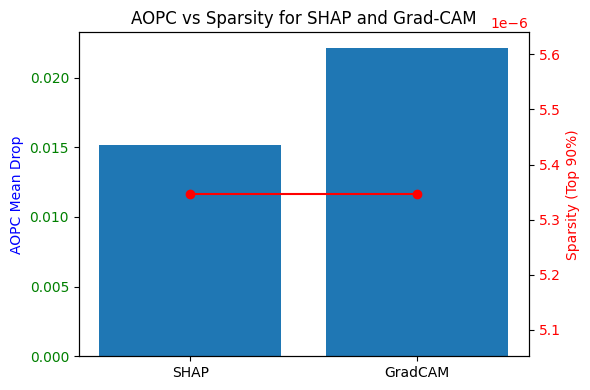

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("explainability_metrics_summary.csv")

# Bar plot comparison
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.bar(df['method'], df['aopc_mean_drop'], label='AOPC Mean Drop')
ax1.set_ylabel('AOPC Mean Drop', color='blue')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(df['method'], df['sparsity_topmass_90'], color='red', marker='o', label='Sparsity (Top 90%)')
ax2.set_ylabel('Sparsity (Top 90%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('AOPC vs Sparsity for SHAP and Grad-CAM')
plt.tight_layout()
plt.show()


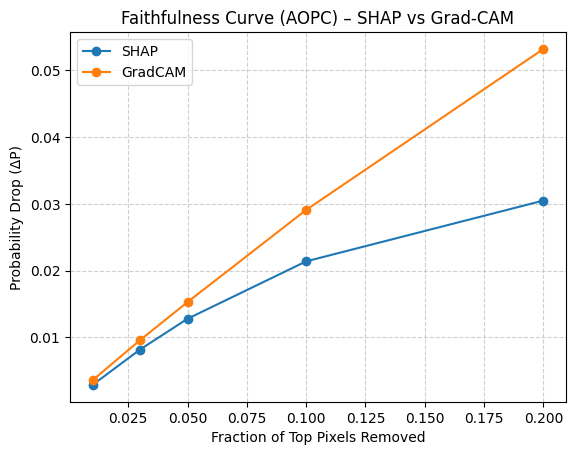

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define perturbation fractions
pert_fracs = [0.01, 0.03, 0.05, 0.1, 0.2]

for i, row in df.iterrows():
    drops = list(map(float, row['prob_drops_by_frac'].split(';')))
    plt.plot(pert_fracs, drops, marker='o', label=row['method'])

plt.xlabel('Fraction of Top Pixels Removed')
plt.ylabel('Probability Drop (ΔP)')
plt.title('Faithfulness Curve (AOPC) – SHAP vs Grad-CAM')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


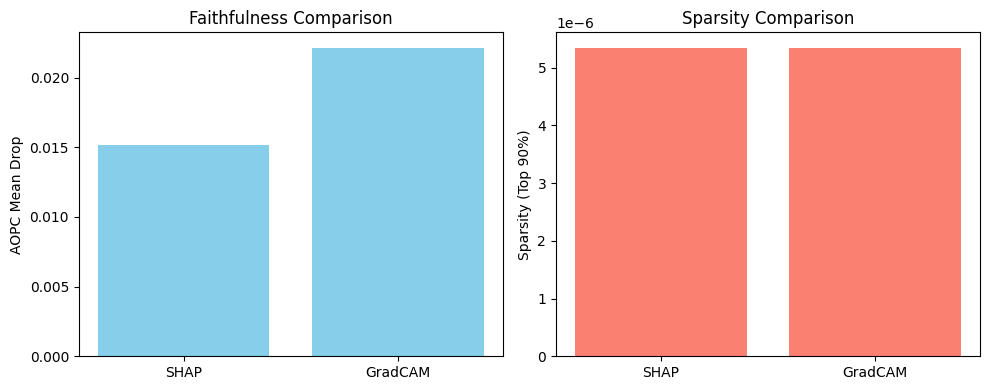

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Left: AOPC & Sparsity
axes[0].bar(df['method'], df['aopc_mean_drop'], color='skyblue', label='AOPC')
axes[0].set_ylabel('AOPC Mean Drop')
axes[0].set_title('Faithfulness Comparison')

axes[1].bar(df['method'], df['sparsity_topmass_90'], color='salmon', label='Sparsity')
axes[1].set_ylabel('Sparsity (Top 90%)')
axes[1].set_title('Sparsity Comparison')

plt.tight_layout()
plt.show()


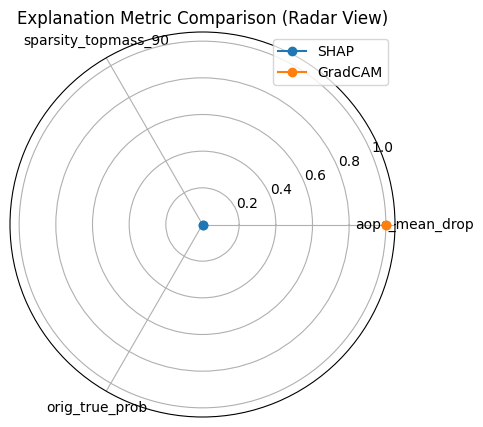

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv("explainability_metrics_summary.csv")

metrics = ['aopc_mean_drop', 'sparsity_topmass_90', 'orig_true_prob']
methods = df['method']
values = [df[m] for m in metrics]

values = [(v - v.min()) / (v.max() - v.min()) for v in values]
values = np.array(values).T

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))

for i, method in enumerate(methods):
    vals = values[i].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, marker='o', label=method)
    ax.fill(angles, vals, alpha=0.2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Explanation Metric Comparison (Radar View)")
plt.legend()
plt.show()


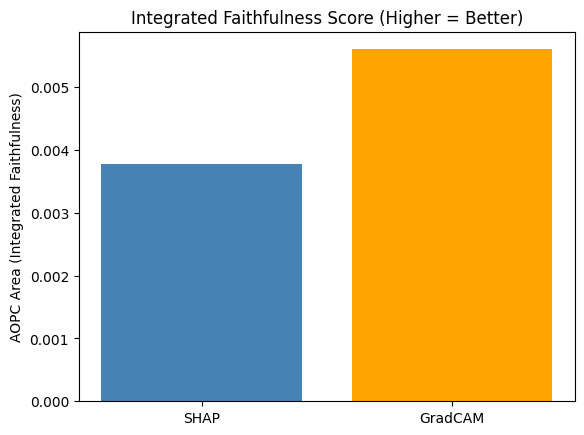

In [14]:
import numpy as np
import matplotlib.pyplot as plt

pert_fracs = np.array([0.01, 0.03, 0.05, 0.1, 0.2])
areas = []

for _, row in df.iterrows():
    drops = np.array(list(map(float, row['prob_drops_by_frac'].split(';'))))
    area = np.trapz(drops, pert_fracs)  # numerical integration
    areas.append(area)

plt.bar(df['method'], areas, color=['steelblue', 'orange'])
plt.ylabel('AOPC Area (Integrated Faithfulness)')
plt.title('Integrated Faithfulness Score (Higher = Better)')
plt.show()


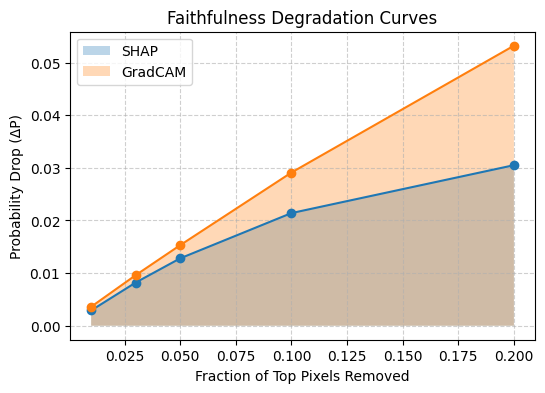

In [15]:
plt.figure(figsize=(6,4))

for _, row in df.iterrows():
    drops = list(map(float, row['prob_drops_by_frac'].split(';')))
    plt.fill_between(pert_fracs, drops, alpha=0.3, label=row['method'])
    plt.plot(pert_fracs, drops, marker='o')

plt.xlabel('Fraction of Top Pixels Removed')
plt.ylabel('Probability Drop (ΔP)')
plt.title('Faithfulness Degradation Curves')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


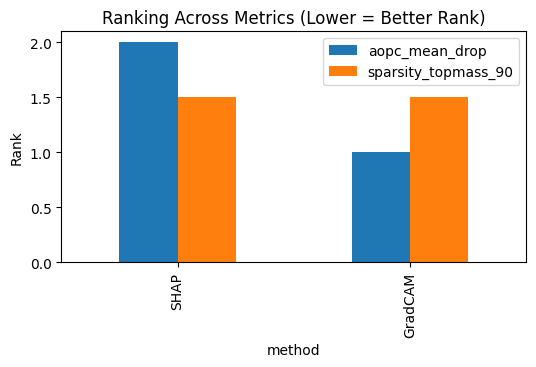

In [16]:
metrics = ['aopc_mean_drop', 'sparsity_topmass_90']
fig, ax = plt.subplots(figsize=(6,3))
rank_data = df.set_index('method')[metrics].rank(ascending=False)
rank_data.plot(kind='bar', ax=ax)
plt.title('Ranking Across Metrics (Lower = Better Rank)')
plt.ylabel('Rank')
plt.show()
